# Near-reference variability

Analysis of near-reference variability across datasets and models for Figure S1.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import iqr, wilcoxon
from statsmodels.stats.weightstats import DescrStatsW

from dynamic_bias import utils
from dynamic_bias.analyses.behavior import NearReferenceStatistics

utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/external")

behavior  = utils.load_behavior()
zamboni   = pd.read_csv(f"{utils.ORIGIN}/data/processed/behavior/zamboni2016.csv")
fritsche  = pd.read_csv(f"{utils.ORIGIN}/data/processed/behavior/fritsche2019.csv")
rademaker = pd.read_csv(f"{utils.ORIGIN}/data/processed/behavior/rademaker2019.csv")

downloading data/external...
data/external already exists. Skipping download...
downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...


---
## Reference repulsion: 1. ours

In [3]:
behavior['evidence'] = -behavior['ref'] 

nrs = NearReferenceStatistics()
bin_evi  = behavior.evidence.values
bins_evi = np.unique(bin_evi)
bin_iqr  = utils.collapse(behavior.error,
                          collapse_groups=[behavior.ID, behavior.evidence],
                          collapse_func=iqr, return_list=True)

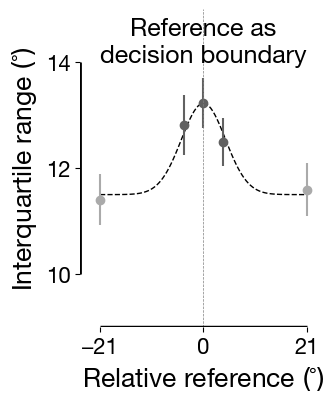

In [4]:
m_iqr, s_iqr = utils.meanstats(bin_iqr, axis=0)
idx_near = np.abs(bins_evi) < nrs.thres
nrs.fit_gaussian(bins_evi, np.array(bin_iqr), init_params=[0,1,1])

plt.figure()
ax = plt.gca()
utils.set_size([2.5,3])
plt.vlines(bins_evi[idx_near], (m_iqr-s_iqr)[idx_near], (m_iqr+s_iqr)[idx_near], color='#616161')
plt.scatter(bins_evi[idx_near], m_iqr[idx_near],  color='#616161')
plt.vlines(bins_evi[~idx_near], (m_iqr-s_iqr)[~idx_near], (m_iqr+s_iqr)[~idx_near], color='#AAAAAA')
plt.scatter(bins_evi[~idx_near], m_iqr[~idx_near], color='#AAAAAA')
plt.xlim([-25,25])
plt.axvline(x=0, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([9,15])

xxx = np.linspace(-21,21,100)
yyy = nrs.centered_gaussian(xxx)
plt.plot(xxx, yyy, color='black', linestyle='dashed', linewidth=1, zorder=-3)

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(10,14), xticks=[-21,0,21], yticks=[10,12,14])
if utils.LABEL:
    plt.xlabel(r'Relative reference $(\!\!^\circ\!\!)$')
    plt.ylabel(r'Interquartile range $(\!\!^\circ\!\!)$')
    plt.text(0,14, 'Reference as\ndecision boundary', fontsize=18, ha='center')

plt.savefig(f'{utils.DIR_FIGURE}/figs1a.pdf',bbox_inches='tight',transparent=True)
plt.show()

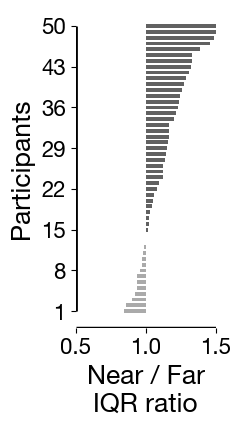

In [5]:
bin_nf = np.select(
    [np.abs(behavior.evidence)<nrs.thres, np.abs(behavior.evidence)>=nrs.thres],
    [0,1], default=np.nan
)
iqr_nf = utils.collapse(behavior.error,
                        collapse_groups=[behavior.ID, bin_nf],
                        collapse_func=iqr, return_list=True)
iqr_nf = np.array(iqr_nf)

plt.figure()
ax = plt.gca()
utils.set_size([1.8,3])

patches = plt.barh(np.arange(len(np.unique(behavior.ID))), 
                   np.sort(iqr_nf[:,0]/iqr_nf[:,1])-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(iqr_nf[:,0]/iqr_nf[:,1])[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')
    
ax.set_xlim([-0.5,0.5])
ax.set_xticks([-0.5,0,0.5])
ax.set_xticklabels([0.5,1.,1.5])
ax.set_yticks([0,7,14,21,28,35,42,49])
ax.set_yticklabels([1,8,15,22,29,36,43,50])

utils.draw_publish_axis(ax, xrange=(-0.5,0.5), yrange=(0,49), xticks=None, yticks=None)
if utils.LABEL:
    plt.xlabel('Near / Far\nIQR ratio')
    plt.ylabel(r'Participants')
plt.savefig(f'{utils.DIR_FIGURE}/figs1b.pdf',bbox_inches='tight',transparent=True)
plt.show()

In [6]:
ttest  = DescrStatsW(iqr_nf[:,0]/iqr_nf[:,1]-1)
wilcox = wilcoxon(iqr_nf[:,0]/iqr_nf[:,1]-1)

print("IQR ratio vs. 1")
print('\nPaired samples t-test')
print(f't({len(iqr_nf)-1})=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', np.array(ttest.tconfint_mean())+1)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

IQR ratio vs. 1

Paired samples t-test
t(49)= 5.432524590467516 p= 1.7288022985514885e-06
95% CI= [1.08671275 1.18852892]

Wilcoxon signed-rank test (without continuity correction)
V= 177.0 p= 2.2310435863204248e-06


---
## Reference repulsion: 2. Zamboni et al. (2016)

In [7]:
zamboni['error'] = utils.wrap(zamboni['relestim']-zamboni['evidence'], period=180)

nrs = NearReferenceStatistics()
bin_evi  = nrs.bin( zamboni.evidence, n_edge=10 )
nnan     = (~np.isnan(bin_evi)) & (~np.isnan(zamboni.error))
bins_evi = np.unique(bin_evi[nnan])
bin_iqr  = utils.collapse(zamboni.error[nnan],
                          collapse_groups=[zamboni.ID[nnan], bin_evi[nnan]],
                          collapse_func=iqr, return_list=True)

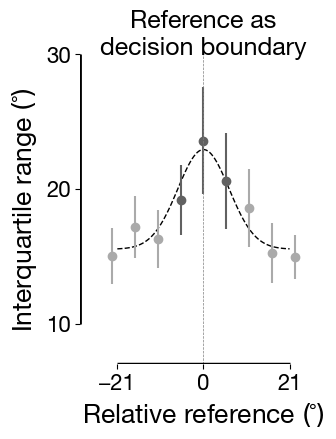

In [8]:
m_iqr, s_iqr = utils.meanstats(bin_iqr, axis=0)
idx_near = np.abs(bins_evi) < nrs.thres
nrs.fit_gaussian(bins_evi, np.array(bin_iqr), init_params=[0,1,1])

plt.figure()
ax = plt.gca()
utils.set_size([2.5,3])
plt.vlines(bins_evi[idx_near], (m_iqr-s_iqr)[idx_near], (m_iqr+s_iqr)[idx_near], color='#616161')
plt.scatter(bins_evi[idx_near], m_iqr[idx_near],  color='#616161')
plt.vlines(bins_evi[~idx_near], (m_iqr-s_iqr)[~idx_near], (m_iqr+s_iqr)[~idx_near], color='#AAAAAA')
plt.scatter(bins_evi[~idx_near], m_iqr[~idx_near], color='#AAAAAA')
plt.xlim([-30,30])
plt.axvline(x=0, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([7,18])

xxx = np.linspace(-21,21,100)
yyy = nrs.centered_gaussian(xxx)
plt.plot(xxx, yyy, color='black', linestyle='dashed', linewidth=1, zorder=-3)

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(10,30), xticks=[-21,0,21], yticks=[10,20,30])
if utils.LABEL:
    plt.xlabel(r'Relative reference $(\!\!^\circ\!\!)$')
    plt.ylabel(r'Interquartile range $(\!\!^\circ\!\!)$')
    plt.text(0,30, 'Reference as\ndecision boundary', fontsize=18, ha='center')

plt.savefig(f'{utils.DIR_FIGURE}/figs1c.pdf',bbox_inches='tight',transparent=True)
plt.show()

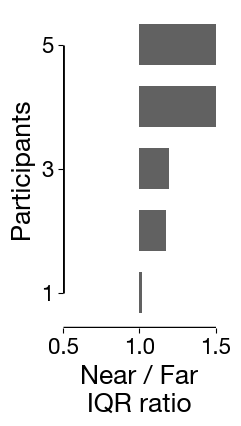

In [9]:
iqr_nf = np.stack([
    np.mean(np.array(bin_iqr)[:,np.abs(bins_evi)<=nrs.thres],axis=-1),
    np.mean(np.array(bin_iqr)[:,np.abs(bins_evi) >nrs.thres],axis=-1)
],axis=-1)

plt.figure()
ax = plt.gca()
utils.set_size([1.8,3])

patches = plt.barh(np.arange(5), np.sort(iqr_nf[:,0]/iqr_nf[:,1])-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(iqr_nf[:,0]/iqr_nf[:,1])[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')
    
ax.set_xlim([-0.5,0.5])
ax.set_xticks([-0.5,0,0.5])
ax.set_xticklabels([0.5,1.,1.5])
ax.set_yticks([0,2,4])
ax.set_yticklabels([1,3,5])

utils.draw_publish_axis(ax, xrange=(-0.5,0.5), yrange=(0,4), xticks=None, yticks=None)
if utils.LABEL:
    plt.xlabel('Near / Far\nIQR ratio')
    plt.ylabel(r'Participants')
plt.savefig(f'{utils.DIR_FIGURE}/figs1d.pdf',bbox_inches='tight',transparent=True)
plt.show()

In [10]:
ttest  = DescrStatsW(iqr_nf[:,0]/iqr_nf[:,1]-1)
wilcox = wilcoxon(iqr_nf[:,0]/iqr_nf[:,1]-1)
print("IQR ratio vs. 1")
print('\nPaired samples t-test')
print(f't({len(iqr_nf)-1})=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', np.array(ttest.tconfint_mean())+1)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

IQR ratio vs. 1

Paired samples t-test
t(4)= 2.700825569641713 p= 0.054048082668473475
95% CI= [0.99156679 1.61083375]

Wilcoxon signed-rank test (without continuity correction)
V= 0.0 p= 0.0625


---
## Reference repulsion: 3. Fritsche et al. (2019)

In [11]:
fritsche['evidence'] = utils.wrap(fritsche['stim']-fritsche['ref'], period=180)
fritsche['error']    = utils.wrap(fritsche['estim']-fritsche['stim'], period=180)

nrs = NearReferenceStatistics( bin_range=15.5 )
bin_evi  = nrs.bin( fritsche.evidence, n_edge=8 )
nnan     = (~np.isnan(bin_evi)) & (~np.isnan(fritsche.error))
bins_evi = np.unique(bin_evi[nnan])
bin_iqr  = utils.collapse(fritsche.error[nnan],
                          collapse_groups=[fritsche.ID[nnan], bin_evi[nnan]],
                          collapse_func=iqr, return_list=True)

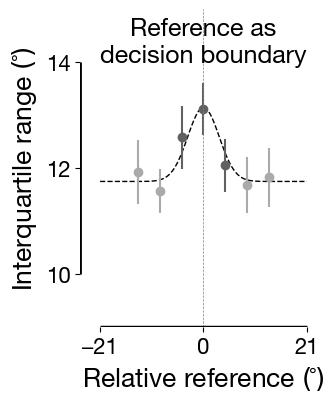

In [12]:
m_iqr, s_iqr = utils.meanstats(bin_iqr, axis=0)
idx_near = np.abs(bins_evi) < nrs.thres
nrs.fit_gaussian(bins_evi, np.array(bin_iqr), init_params=[0,1,1])

plt.figure()
ax = plt.gca()
utils.set_size([2.5,3])
plt.vlines(bins_evi[idx_near], (m_iqr-s_iqr)[idx_near], (m_iqr+s_iqr)[idx_near], color='#616161')
plt.scatter(bins_evi[idx_near], m_iqr[idx_near],  color='#616161')
plt.vlines(bins_evi[~idx_near], (m_iqr-s_iqr)[~idx_near], (m_iqr+s_iqr)[~idx_near], color='#AAAAAA')
plt.scatter(bins_evi[~idx_near], m_iqr[~idx_near], color='#AAAAAA')
plt.xlim([-25,25])
plt.axvline(x=0, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([9,15])

xxx = np.linspace(-21,21,100)
yyy = nrs.centered_gaussian(xxx)
plt.plot(xxx, yyy, color='black', linestyle='dashed', linewidth=1, zorder=-3)

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(10,14), xticks=[-21,0,21], yticks=[10,12,14])
if utils.LABEL:
    plt.xlabel(r'Relative reference $(\!\!^\circ\!\!)$')
    plt.ylabel(r'Interquartile range $(\!\!^\circ\!\!)$')
    plt.text(0,14, 'Reference as\ndecision boundary', fontsize=18, ha='center')

plt.savefig(f'{utils.DIR_FIGURE}/figs1e.pdf',bbox_inches='tight',transparent=True)
plt.show()

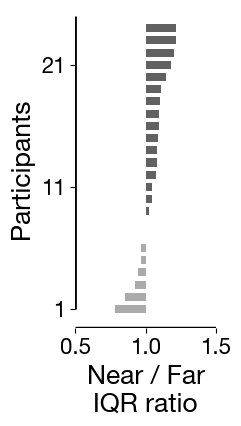

In [13]:
bin_nf = np.select(
    [np.abs(fritsche.evidence)<nrs.thres, np.abs(fritsche.evidence)>=nrs.thres],
    [0,1], default=np.nan
)
iqr_nf = utils.collapse(fritsche.error[nnan],
                        collapse_groups=[fritsche.ID[nnan], bin_nf[nnan]],
                        collapse_func=iqr, return_list=True)
iqr_nf = np.array(iqr_nf)

plt.figure()
ax = plt.gca()
utils.set_size([1.8,3])
patches = plt.barh(np.arange(24), np.sort(iqr_nf[:,0]/iqr_nf[:,1])-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(iqr_nf[:,0]/iqr_nf[:,1])[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')
    
ax.set_xlim([-0.5,0.5])
ax.set_xticks([-0.5,0,0.5])
ax.set_xticklabels([0.5,1.,1.5])
ax.set_yticks([0,10,20])
ax.set_yticklabels([1,11,21])

utils.draw_publish_axis(ax, xrange=(-0.5,0.5), yrange=(0,24), xticks=None, yticks=None)

if utils.LABEL:
    plt.xlabel('Near / Far\nIQR ratio')
    plt.ylabel(r'Participants')
plt.savefig(f'{utils.DIR_FIGURE}/figs1f.pdf',bbox_inches='tight',transparent=True)
plt.show()

In [14]:
ttest  = DescrStatsW(iqr_nf[:,0]/iqr_nf[:,1]-1)
wilcox = wilcoxon(iqr_nf[:,0]/iqr_nf[:,1]-1)
print("IQR ratio vs. 1")
print('\nPaired samples t-test')
print(f't({len(iqr_nf)-1})=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', np.array(ttest.tconfint_mean())+1)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

IQR ratio vs. 1

Paired samples t-test
t(23)= 2.3805579791711975 p= 0.025955760108732195
95% CI= [1.00699409 1.0997697 ]

Wilcoxon signed-rank test (without continuity correction)
V= 68.0 p= 0.017870306968688965


---
## Reference attraction: Rademaker et al. (2019)

When the intervening reference serves as a distractor.

In [15]:
rademaker['evidence'] = utils.wrap(rademaker['stim'] -rademaker['ref'],  period=180)
rademaker['error']    = utils.wrap(rademaker['estim']-rademaker['stim'], period=180)

nrs = NearReferenceStatistics()
bin_evi  = nrs.bin( rademaker.evidence, n_edge=7 )
nnan     = (~np.isnan(bin_evi)) & (~np.isnan(rademaker.error))
bins_evi = np.unique(bin_evi[nnan])
bin_iqr  = utils.collapse(rademaker.error[nnan],
                          collapse_groups=[rademaker.ID[nnan], bin_evi[nnan]],
                          collapse_func=iqr, return_list=True)

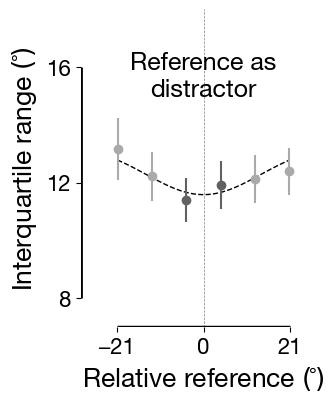

In [16]:
m_iqr, s_iqr = utils.meanstats(bin_iqr, axis=0)
idx_near = np.abs(bins_evi) < nrs.thres
nrs.fit_gaussian(bins_evi, np.array(bin_iqr), init_params=[0,1,-1])

plt.figure()
ax = plt.gca()
utils.set_size([2.5,3])
plt.vlines(bins_evi[idx_near], (m_iqr-s_iqr)[idx_near], (m_iqr+s_iqr)[idx_near], color='#616161')
plt.scatter(bins_evi[idx_near], m_iqr[idx_near],  color='#616161')

plt.vlines(bins_evi[~idx_near], (m_iqr-s_iqr)[~idx_near], (m_iqr+s_iqr)[~idx_near], color='#AAAAAA')
plt.scatter(bins_evi[~idx_near], m_iqr[~idx_near], color='#AAAAAA')
plt.xlim([-30,30])
plt.axvline(x=0, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([7,18])

xxx = np.linspace(-21,21,100)
yyy = nrs.centered_gaussian(xxx)
plt.plot(xxx, yyy, color='black', linestyle='dashed', linewidth=1, zorder=-3)

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(8,16), xticks=[-21,0,21], yticks=[8,12,16])
if utils.LABEL:
    plt.text(0,15, 'Reference as\ndistractor', fontsize=18, ha='center')
    plt.xlabel(r'Relative reference $(\!\!^\circ\!\!)$')
    plt.ylabel(r'Interquartile range $(\!\!^\circ\!\!)$')
plt.savefig(f'{utils.DIR_FIGURE}/figs1g.pdf',bbox_inches='tight',transparent=True)
plt.show()

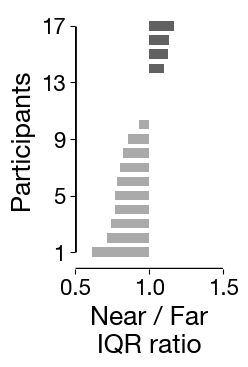

In [17]:
bin_nf = np.select(
    [np.abs(rademaker.evidence)<nrs.thres, np.abs(rademaker.evidence)>=nrs.thres],
    [0,1], default=np.nan
)
iqr_nf = utils.collapse(rademaker.error[nnan],
                        collapse_groups=[rademaker.ID[nnan], bin_nf[nnan]],
                        collapse_func=iqr, return_list=True)
iqr_nf = np.array(iqr_nf)

plt.figure()
ax = plt.gca()
utils.set_size([2.1,3])

patches = plt.barh(np.arange(17), 
                   np.sort(iqr_nf[:,0]/iqr_nf[:,1])-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(iqr_nf[:,0]/iqr_nf[:,1])[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')

ax.set_xlim([-0.5,0.5])
ax.set_xticks([-0.5,0,0.5])
ax.set_xticklabels([0.5,1.,1.5])
ax.set_yticks([0,4,8,12,16])
ax.set_yticklabels([1,5,9,13,17])
if utils.LABEL:
    plt.xlabel('Near / Far\nIQR ratio')
    plt.ylabel(r'Participants')
utils.draw_publish_axis(ax, xrange=(-0.5,0.5), yrange=(0,16), xticks=None, yticks=None)
plt.savefig(f'{utils.DIR_FIGURE}/figs1h.pdf',bbox_inches='tight',transparent=True)
plt.show()

In [19]:
ttest  = DescrStatsW(iqr_nf[:,0]/iqr_nf[:,1]-1)
wilcox = wilcoxon(iqr_nf[:,0]/iqr_nf[:,1]-1)

print("IQR ratio vs. 1")
print('\nPaired samples t-test')
print(f't({len(iqr_nf)-1})=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', np.array(ttest.tconfint_mean())+1)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

IQR ratio vs. 1

Paired samples t-test
t(16)= -2.4265213645437114 p= 0.027430264525795035
95% CI= [0.81375686 0.98743956]

Wilcoxon signed-rank test (without continuity correction)
V= 15.0 p= 0.018537758580547185
